In [1]:
# For better printing within jupyter cells
import IPython
IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

# Basic python libraries
import matplotlib.pyplot as mpl # doc: https://matplotlib.org/tutorials
import numpy                    # doc: https://numpy.org/doc/stable
import sympy                    # doc: https://docs.sympy.org

In [2]:
%%capture
# By these two lines, it will not be needed to restart kernel when applying change in a library
%load_ext autoreload
%autoreload 2

# import main
import dolfin  
import numpy    as np
import sympy    as sp
import matplotlib.pyplot as plt
import math
import gmsh
import meshio
import sys
from numpy import linspace
from sympy import lambdify
import seaborn as sns

import myPythonLibrary as mypy
import dolfin_mech     as dmech
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

from scipy.optimize import fsolve

from matplotlib import cm


## Parameters

In [3]:
lmbda = sympy.Symbol('lambda') # lambda is a reserved keyword in python, it cannot be used as a name for a variable.
mu    = sympy.Symbol('mu')

print ("lmbda:"); lmbda
print ("mu:"   ); mu

lmbda:


lambda

mu:


mu

In [4]:
dim = 2
fname = "Geometries/Hexagon/hexagon_RVE1"
# fname = 'Geometries/Hallow_square/Hallow_square_inclusion_inside'

mesh = dolfin.Mesh()
dolfin.XDMFFile(fname+"-mesh.xdmf").read(mesh)

dV = dolfin.Measure("dx",domain=mesh)
coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

vol = (xmax - xmin)*(ymax - ymin)
bbox = [xmin, xmax, ymin, ymax]


In [27]:
E_     = 1.  # (Pa)
nu_    = 0.499 # ()

mat_params = {"model":"CGNH", "parameters":{"E":E_, "nu":nu_}}
homo = dmech.HomogenizationLinear(dim=dim,
                mesh=mesh,
                mat_params=mat_params["parameters"],
                vol=vol,
                bbox=bbox)
[mu_, lmbda_] = homo.get_lambda_and_mu()

# lmbda_ = E_ * nu_ / (1 + nu_) / (1 - 2 * nu_)
# mu_    = E_ / 2 / (1 + nu_)
print ("lmbda_:"); lmbda_
print ("mu_:"   ); mu_
K_ = lmbda_ + 2*mu_/3
G_ = mu_

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
lmbda_:


0.032565142567563536

mu_:


0.15767990967151904

In [7]:
subs_dict        = {}
subs_dict[lmbda] = lmbda_
subs_dict[mu]    = mu_
print ("subs_dict:"); subs_dict

print ("lmbda:"); lmbda.subs(subs_dict)
print ("mu:"   ); mu.subs(subs_dict)

subs_dict:


{lambda: 0.032565142567563536, mu: 0.15767990967151904}

lmbda:


0.0325651425675635

mu:


0.157679909671519

## Behavior models

### Kinematics variables

In [8]:
# Cauchy-Green dilatation tensor
C_var = sympy.MatrixSymbol('C', 2, 2).as_explicit()
print ("C_var:"); C_var

C_inv_var = sympy.Inverse(C_var)
print ("C_inv_var:"); C_inv_var.doit()

# Invariants
I_C_var   = sympy.trace(C_var)
III_C_var = sympy.det(C_var)
J_var     = sympy.sqrt(III_C_var)
print (  "I_C:"); I_C_var
print ("III_C:"); III_C_var
print (    "J:"); J_var

# Reduced invariants
I_bar_C_var = sympy.root(J_var, -sympy.Rational(3, 2)) * I_C_var
print ("I_bar_C:"); I_bar_C_var


C_var:


Matrix([
[C[0, 0], C[0, 1]],
[C[1, 0], C[1, 1]]])

C_inv_var:


Matrix([
[ C[1, 1]/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]), -C[0, 1]/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])],
[-C[1, 0]/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]),  C[0, 0]/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])]])

I_C:


C[0, 0] + C[1, 1]

III_C:


C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]

J:


sqrt(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])

I_bar_C:


(C[0, 0] + C[1, 1])/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**(1/3)

### Coupled model

In [9]:
p_f = sympy.symbols('p_f')

# Neo-Hookean free energy potential
W_c =   (lmbda/4) * (J_var**2 - 1 - 2 * sympy.ln(J_var)) \
      + (   mu/2) * (I_C_var  - 2 - 2 * sympy.ln(J_var))
# print ("W_c:"); W_c
print ("W_c:"); W_c.simplify()

# Second Piola-Kirchhoff stress tensor
Sigma_c = 2*sympy.diff(W_c, C_var) - p_f * J_var * C_var.inv()
# print ("Sigma_c:"); Sigma_c
# print ("Sigma_c:"); Sigma_c.doit()
# print ("Sigma_c:"); Sigma_c.doit().as_explicit()

p_c = - (sympy.trace(Sigma_c.T * C_var) + lmbda/2 * (J_var**2 - 1))/3/J_var
# print ("p_c:"); p_c

Sigma_d_c = Sigma_c + p_c * J_var * C_inv_var
# print ("Sigma_d_c:"); Sigma_d_c

W_c:


-lambda*(log(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]) - C[0, 0]*C[1, 1] + C[0, 1]*C[1, 0] + 1)/4 - mu*(log(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]) - C[0, 0] - C[1, 1] + 2)/2

### Decoupled model

In [10]:
K = lmbda + 2*mu/3
G = mu

# Neo-Hookean free energy potential
W_d = (K/4) * (J_var**2 - 1 - 2 * sympy.ln(J_var)) \
    + (G/2) * (J_var**(-2/3)*(1+ I_C_var) - 3)
print ("W_d:"); W_d.simplify()  

# Second Piola-Kirchhoff stress tensor
Sigma_d = 2*sympy.diff(W_d, C_var) - p_f * J_var * C_var.inv()
# print ("Sigma_d:"); Sigma_d
# print ("Sigma_d:"); Sigma_d.doit()
# print ("Sigma_d:"); Sigma_d.doit().as_explicit()

p_d = - (sympy.trace(Sigma_d.T * C_var) + J_var**(-2/3)*(1 - (sympy.Trace(C_var) + 1)/3)*G + K/2 * (J_var**2 - 1))/3/J_var
# print ("p_d:"); p_d

Sigma_d_d = Sigma_d + p_d * J_var * C_inv_var
# print ("Sigma_d_d:"); Sigma_d_d

W_d:


(6*mu*(-3*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**0.333333333333333 + C[0, 0] + C[1, 1] + 1) - (3*lambda + 2*mu)*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**0.333333333333333*(log(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0]) - C[0, 0]*C[1, 1] + C[0, 1]*C[1, 0] + 1))/(12*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**0.333333333333333)

## Stress-strain responses

### Deviatoric deformation

In [11]:
# Deformation gradient
# In principle we could define X and x and use tensor derivative, but that is a bit involved.
beta = sympy.symbols('beta')
F = sympy.Matrix(
    [[beta, 0     ],\
     [0   , 1/beta]])
print ("F:"); F

# Determinant of deformation gradient (a.k.a. Jacobian)
J = F.det()
print ("J:"); J

# Right Cauchy-Green dilatation tensor
C = F.T * F
print ("C:"); C

C_inv = sympy.Inverse(C).doit()
print ("C_inv:"); C_inv

# Green-Lagrange strain tensor
E = (C - sympy.eye(2))/2
print ("E:"); E

F:


Matrix([
[beta,      0],
[   0, 1/beta]])

J:


1

C:


Matrix([
[beta**2,          0],
[      0, beta**(-2)]])

C_inv:


Matrix([
[beta**(-2),       0],
[         0, beta**2]])

E:


Matrix([
[beta**2/2 - 1/2,                    0],
[              0, -1/2 + 1/(2*beta**2)]])

#### Coupled model

In [12]:
# Second Piola-Kirchhoff stress tensor
Sigma = Sigma_c.subs(list(zip(C_var, C))).doit().as_explicit() # list & zip should not be needed, cf. https://github.com/sympy/sympy/issues/10589
print ("Sigma:"); Sigma

# Hydrostatic pressure
p_c_shear = p_c.subs(list(zip(C_var, C))).doit()
print ("p:"); p_c_shear.simplify()

# Deviatoric stress tensor
Sigma_d_c = Sigma_d_c.subs(list(zip(C_var, C))).doit().as_explicit()
print ("Sigma_d:"); Sigma_d.simplify()
Sigma_c_VM = sympy.sqrt(1.5 * sympy.Trace(Sigma_d_c.T * Sigma_d_c))

Sigma:


Matrix([
[mu*(1 - 1/beta**2) - p_f/beta**2,                               0],
[                               0, -beta**2*p_f + mu*(1 - beta**2)]])

p:


-beta**2*mu/3 + 2*mu/3 + 2*p_f/3 - mu/(3*beta**2)

Sigma_d:


Matrix([
[(-mu*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**(3/2)*(0.333333333333333*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**0.333333333333333*(C[0, 0] + C[1, 1] + 1)*C[1, 1] - (C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**1.33333333333333) - p_f*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.66666666666667*C[1, 1] + (3*lambda + 2*mu)*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.16666666666667*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0] - 1)*C[1, 1]/6)/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**3.16666666666667,                                                                                                                   (0.333333333333333*mu*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**(3/2)*(C[0, 0] + C[1, 1] + 1)*C[1, 0] + p_f*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.33333333333333*C[0, 1] - (3*lambda + 2*mu)*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**1.83333333333333*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0] - 1)*C[1, 0]/6)/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.83333333333333],
[                                                                      

#### Decoupled model

In [13]:
# Second Piola-Kirchhoff stress tensor
Sigma = Sigma_d.subs(list(zip(C_var, C))).doit().as_explicit() # list & zip should not be needed, cf. https://github.com/sympy/sympy/issues/10589
print ("Sigma:"); Sigma

# Hydrostatic pressure
p_d_shear = p_d.subs(list(zip(C_var, C))).doit()
print ("p:"); p_d_shear.simplify()

# Deviatoric stress tensor
Sigma_d_d = Sigma_d_d.subs(list(zip(C_var, C))).doit().as_explicit()
print ("Sigma_d:"); Sigma_d.simplify()
Sigma_d_VM = sympy.sqrt(1.5 * sympy.Trace(Sigma_d_d.T * Sigma_d_d))

Sigma:


Matrix([
[mu*(1 - 0.333333333333333*(beta**2 + 1 + beta**(-2))/beta**2) - p_f/beta**2,                                                                             0],
[                                                                          0, -beta**2*p_f + mu*(-0.333333333333333*beta**2*(beta**2 + 1 + beta**(-2)) + 1)]])

p:


2*p_f/3

Sigma_d:


Matrix([
[(-mu*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**(3/2)*(0.333333333333333*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**0.333333333333333*(C[0, 0] + C[1, 1] + 1)*C[1, 1] - (C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**1.33333333333333) - p_f*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.66666666666667*C[1, 1] + (3*lambda + 2*mu)*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.16666666666667*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0] - 1)*C[1, 1]/6)/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**3.16666666666667,                                                                                                                   (0.333333333333333*mu*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**(3/2)*(C[0, 0] + C[1, 1] + 1)*C[1, 0] + p_f*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.33333333333333*C[0, 1] - (3*lambda + 2*mu)*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**1.83333333333333*(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0] - 1)*C[1, 0]/6)/(C[0, 0]*C[1, 1] - C[0, 1]*C[1, 0])**2.83333333333333],
[                                                                      

## Micromechanical Model

In [14]:
def global_response(mesh, mat_params, eps_xx, eps_yy, pf, sigma_bar, foi_name):


    dim = 2
    bcs = "pbc"
    step_params = {"dt_ini":1e-1, "dt_min":1e-3}


    res_folder = sys.argv[0][:-3]
    res_basename  = sys.argv[0][:-3]

    res_basename = res_folder+"/"+res_basename
    verbose=1

    ################################################################### Mesh ###

    

    dV = dolfin.Measure("dx",domain=mesh)
    coord = mesh.coordinates()
    xmax = max(coord[:,0]); xmin = min(coord[:,0])
    ymax = max(coord[:,1]); ymin = min(coord[:,1])
    if (dim==3): zmax = max(coord[:,2]); zmin = min(coord[:,2])
    if (dim==2):    
        vol = (xmax - xmin)*(ymax - ymin)
        
        bbox = [xmin, xmax, ymin, ymax]

    if (dim==3):    
        vol = (xmax - xmin)*(ymax - ymin)*(zmax - zmin)
        bbox = [xmin, xmax, ymin, ymax, zmin, zmax]

    mesh_corners = np.array([[xmin, ymin],
                         [xmax, ymin],
                         [xmax, ymax],
                         [xmin, ymax]])

    ################################################## Subdomains & Measures ###

    xmin_sd = dolfin.CompiledSubDomain("near(x[0], x0) && on_boundary", x0=xmin)
    xmax_sd = dolfin.CompiledSubDomain("near(x[0], x0) && on_boundary", x0=xmax)
    ymin_sd = dolfin.CompiledSubDomain("near(x[1], x0) && on_boundary", x0=ymin)
    ymax_sd = dolfin.CompiledSubDomain("near(x[1], x0) && on_boundary", x0=ymax)
    if (dim==3): zmin_sd = dolfin.CompiledSubDomain("near(x[2], x0) && on_boundary", x0=zmin)
    if (dim==3): zmax_sd = dolfin.CompiledSubDomain("near(x[2], x0) && on_boundary", x0=zmax)


    xmin_id = 1
    xmax_id = 2
    ymin_id = 3
    ymax_id = 4
    if (dim==3): zmin_id = 5
    if (dim==3): zmax_id = 6
    # sint_id = 9

    boundaries_mf = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim()-1) # MG20180418: size_t looks like unisgned int, but more robust wrt architecture and os
    boundaries_mf.set_all(0)
    xmin_sd.mark(boundaries_mf, xmin_id)
    xmax_sd.mark(boundaries_mf, xmax_id)
    ymin_sd.mark(boundaries_mf, ymin_id)
    ymax_sd.mark(boundaries_mf, ymax_id)
    if (dim==3): zmin_sd.mark(boundaries_mf, zmin_id)
    if (dim==3): zmax_sd.mark(boundaries_mf, zmax_id)
    # sint_sd.mark(boundaries_mf, sint_id)

    if (verbose):
        xdmf_file_boundaries = dolfin.XDMFFile(res_basename+"-boundaries.xdmf")
        xdmf_file_boundaries.write(boundaries_mf)
        xdmf_file_boundaries.close()

    ################################################################ Problem ###

    problem = dmech.MicroPoroHyperelasticityProblem(
            mesh=mesh,
            mesh_bbox=bbox,
            boundaries_mf=boundaries_mf,
            displacement_perturbation_degree=1,
            quadrature_degree=3,
            solid_behavior=mat_params,
            bcs=bcs)

    ################################################################ Loading ###

    Deltat = step_params.get("Deltat", 1.)
    dt_ini = step_params.get("dt_ini", 1.)
    dt_min = step_params.get("dt_min", 1.)
    dt_max = step_params.get("dt_max", 1.)
    k_step = problem.add_step(
        Deltat=Deltat,
        dt_ini=dt_ini,
        dt_min=dt_min,
        dt_max=dt_max)

    problem.add_surface_pressure_loading_operator(
        measure=problem.dS(0),
        P_ini=0., P_fin=pf,
        k_step=k_step)

    for k in range(dim):
        for l in range (dim):
            if (sigma_bar[k][l] is not None):
                problem.add_macroscopic_stress_component_constraint_operator(
                    i=k, j=l,
                    sigma_bar_ij_ini=0.0, sigma_bar_ij_fin=sigma_bar[k][l],
                    pf_ini=0.0, pf_fin=pf,
                    k_step=k_step)

    problem.add_macroscopic_stretch_component_penalty_operator(
        i=0, j=0,
        U_bar_ij_ini=0.0, U_bar_ij_fin=eps_xx,
        pen_val=1e9,
        k_step=k_step)
    problem.add_macroscopic_stretch_component_penalty_operator(
        i=1, j=1,
        U_bar_ij_ini=0.0, U_bar_ij_fin=eps_yy,
        pen_val=1e9,
        k_step=k_step)


    ################################################################# Solver ###

    solver = dmech.NonlinearSolver(
        problem=problem,
        parameters={
            "sol_tol":[1e-6]*len(problem.subsols),
            "n_iter_max":32},
        relax_type="constant",
        write_iter=0)

    integrator = dmech.TimeIntegrator(
        problem=problem,
        solver=solver,
        parameters={
            "n_iter_for_accel":4,
            "n_iter_for_decel":16,
            "accel_coeff":2,
            "decel_coeff":2},
        print_out=res_basename*verbose,
        print_sta=res_basename*verbose,
        write_qois=res_basename+"-qois",
        write_qois_limited_precision=1,
        write_sol=res_basename*verbose)

    success = integrator.integrate()
    assert (success),\
        "Integration failed. Aborting."

    integrator.close()
    

    ############################################################################
    
    Vs0 = problem.mesh_V0
    U_bar = problem.get_macroscopic_stretch_subsol().func.vector().get_local().reshape((2,2))
    F_bar = U_bar + numpy.eye(2)
    J_bar = numpy.linalg.det(F_bar)
    C_bar = F_bar.T * F_bar
    E_bar = 0.5*(C_bar - np.eye(2))
    v = J_bar * vol
    vs = dolfin.assemble(problem.kinematics.J * problem.dV)
    vf = v - vs
    
    Phi_s = vs/vol

    for operator in problem.operators: 
        if hasattr(operator, "material"):
            material = operator.material
            break
    
    sigma_tot_xx = float((dolfin.assemble(material.sigma[0,0] * problem.kinematics.J * dV) - vf * pf *dolfin.Identity(2)[0,0])/v)
    sigma_tot_yy = float((dolfin.assemble(material.sigma[1,1] * problem.kinematics.J * dV) - vf * pf *dolfin.Identity(2)[1,1])/v)

    
    sigma = [[sigma_tot_xx, 0.],
             [0., sigma_tot_yy]]
    
    Sigma = J_bar * np.linalg.inv(F_bar)* sigma * np.linalg.inv(F_bar.T)
    # Sigma_x = float(Sigma[0, 0])
    # # Sigma_x = dolfin.assemble(material.Sigma[0,0]*dV)/vol
    # # Sigma_y = dolfin.assemble(material.Sigma[1,1]*dV)/vol    

    p_hydro = - dolfin.assemble(((dolfin.tr(material.Sigma.T*problem.kinematics.C) + material.Sigma_zz)/3/problem.kinematics.J)*problem.dV)/vol

    data_dist = None
    for i in range(len(problem.fois)):
        if problem.fois[i].name == foi_name:
            data_dist = problem.fois[i].func.vector().get_local()

    return p_hydro, data_dist


In [15]:
sigma_bar = [[0., 0.],
             [0., 0.]]

### Coupled

In [20]:
p_lst_micro_c = []
p_lst_macro_c = []
beta_lst = []
mat_params = {"model":"CGNH", "parameters":{"E":E_, "nu":nu_}}

for i  in range(11):
    beta_ = 1 + i/10
    beta_lst.append(beta_)
    p_lst_micro_c.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=beta_-1, eps_yy=1/beta_-1, pf=0., sigma_bar=sigma_bar, foi_name=None)[0])
    p_lst_macro_c.append(p_c_shear.subs(subs_dict).subs(beta, beta_).subs(p_f, 0))

In [21]:
p_lst_micro_d = []
p_lst_macro_d = []

mat_params = {"model":"CGNH_bar", "parameters":{"E":E_, "nu":nu_}}

for i  in range(11):
    beta_ = 1 + i/10
    p_lst_micro_d.append(global_response(mesh=mesh, mat_params=mat_params, eps_xx=beta_-1, eps_yy=1/beta_-1, pf=0., sigma_bar=sigma_bar, foi_name=None)[0])
    p_lst_macro_d.append(p_d_shear.subs(subs_dict).subs(beta, beta_).subs(p_f, 0))

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, '$\\beta$')

Text(0, 0.5, '$p_{hydro} (kPa)$')

(1.0, 2.0)

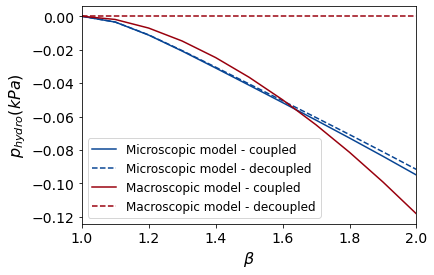

In [22]:
plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$p_{hydro} (kPa)$', fontsize=16)

plt.plot(beta_lst, p_lst_micro_c, '#084594')
plt.plot(beta_lst, p_lst_micro_d, '#084594', linestyle='dashed')

plt.plot(beta_lst, p_lst_macro_c, '#99000D')
plt.plot(beta_lst, p_lst_macro_d, '#99000D', linestyle='dashed')


plt.legend(['Microscopic model - coupled', 'Microscopic model - decoupled', 'Macroscopic model - coupled', 'Macroscopic model - decoupled'])
plt.xlim(1, 2)
# plt.ylim(-.05, 0.001)
plt.savefig('p_hydro.pdf',bbox_inches='tight')
plt.show()

# Frequency Distribution

In [39]:
mode = 'p_hydro'
# mode = 'Sigma_VM'
# pressure = True
# pressure = False
pf_ = 0.
beta_ = 1.5

data_dist_micro =  global_response(mesh=mesh, mat_params=mat_params, eps_xx=beta_-1, eps_yy=1/beta_-1, pf=pf_, sigma_bar=sigma_bar, foi_name=mode)[1]

if mode == 'p_hydro':
    data_macro = p_c_shear.subs(beta, beta_).subs(subs_dict).subs(p_f, pf_)
else:
    data_macro = Sigma_c_VM.subs(beta, beta_).subs(subs_dict).subs(p_f, pf_).simplify()

HDF5-DIAG: Error detected in HDF5 (1.10.6) MPI-process 0:
  #000: H5D.c line 151 in H5Dcreate2(): unable to create dataset
    major: Dataset
    minor: Unable to initialize object
  #001: H5Dint.c line 337 in H5D__create_named(): unable to create and link to dataset
    major: Dataset
    minor: Unable to initialize object
  #002: H5L.c line 1592 in H5L_link_object(): unable to create new link to object
    major: Links
    minor: Unable to initialize object
  #003: H5L.c line 1833 in H5L__create_real(): can't insert link
    major: Links
    minor: Unable to insert object
  #004: H5Gtraverse.c line 851 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #005: H5Gtraverse.c line 627 in H5G__traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #006: H5L.c line 1628 in H5L__link_cb(): name already exists
    major: Links
    minor: Object already exists
HDF5-DIAG: Error detected in HDF5 (1.10.

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Hydrostatic pressure (kPa)')

Text(0, 0.5, 'Frequency distribution')

<AxesSubplot:xlabel='Hydrostatic pressure (kPa)', ylabel='Frequency distribution'>

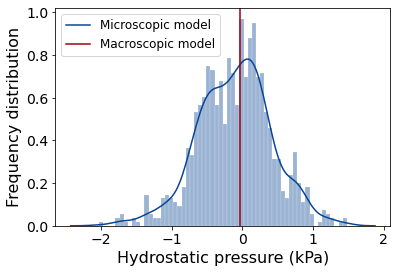

In [40]:
plt.figure()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)        
plt.xlabel('Hydrostatic pressure (kPa)', fontsize=16)
# plt.xlabel('Von Mises stress (kPa)', fontsize=16)
plt.ylabel('Frequency distribution', fontsize=16)

sns.histplot(data_dist_micro, bins=60, kde=True, color = '#084594',
        stat="density", kde_kws=dict(cut=3),
        alpha=0.4, edgecolor=(1, 1, 1, .4))
plt.axvline(x = data_macro, color = '#99000D', label = 'axvline - full height')
plt.legend(['Microscopic model', 'Macroscopic model'])

# sns.histplot(data=data, bins=100, log_scale=True, element="step", fill=False, stat="density")
# plt.xlim(1, 2)
# plt.ylim(-.05, 0.001)
plt.savefig('p_hydro_density_P00.pdf',bbox_inches='tight')
# plt.savefig('Sigma_VM_density_P02.pdf',bbox_inches='tight')
plt.show()
